In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd
# from src.multi_vae_pemb import CrossSpeciesVAE
from src.multi_vae import CrossSpeciesVAE
from src.callbacks import StageAwareEarlyStopping
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap
import hnswlib

def _tanh_scale(x,scale=10,center=0.5):
    return center + (1-center) * np.tanh(scale * (x - center))

def _united_proj(wpca1, wpca2, k=20, metric="cosine", ef=200, M=48):

    metric = 'l2' if metric == 'euclidean' else metric
    metric = 'cosine' if metric == 'correlation' else metric
    labels2 = np.arange(wpca2.shape[0])
    p2 = hnswlib.Index(space=metric, dim=wpca2.shape[1])
    p2.init_index(max_elements=wpca2.shape[0], ef_construction=ef, M=M)
    p2.add_items(wpca2, labels2)
    p2.set_ef(ef)
    idx1, dist1 = p2.knn_query(wpca1, k=k)

    if metric == 'cosine':
        dist1 = 1 - dist1
        dist1[dist1 < 1e-3] = 1e-3
        dist1 = dist1/dist1.max(1)[:,None]
        dist1 = _tanh_scale(dist1,scale=10, center=0.7)
    else:
        sigma1 = dist1[:,4]
        sigma1[sigma1<1e-3]=1e-3
        dist1 = np.exp(-dist1/sigma1[:,None])
        
    Sim1 = dist1  # np.exp(-1*(1-dist1)**2)
    knn1v2 = sp.sparse.lil_matrix((wpca1.shape[0], wpca2.shape[0]))
    x1 = np.tile(np.arange(idx1.shape[0])[:, None], (1, idx1.shape[1])).flatten()
    knn1v2[x1.astype('int32'), idx1.flatten().astype('int32')] = Sim1.flatten()
    return knn1v2.tocsr()

from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=15, metric='correlation'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata1 = anndata.read_h5ad('data/wagner/data.h5ad')
adata2 = anndata.read_h5ad('data/briggs/data.h5ad')

adata1.X = adata1.X.astype('float32')
adata2.X = adata2.X.astype('float32')

emb1 = pickle.load(open('data/wagner/gene_embeddings.pkl','rb'))
emb2 = pickle.load(open('data/briggs/gene_embeddings.pkl','rb'))

emb1 = torch.cat([torch.tensor(emb1[i]).unsqueeze(-2) for i in adata1.var_names],dim=0).float()
emb2 = torch.cat([torch.tensor(emb2[i]).unsqueeze(-2) for i in adata2.var_names],dim=0).float()

I found that homology edges derived from ESM-C give better-than-random mappings. Real signal.


Learning rate needs to be lower to get integration to be better, I've found, but warmup epochs needs to be increased (5.0)


Homologous gene pairs give much better within-species reconstructions. I feel like we probably need a skip connection for the protein embedding model.

Currently trying with a skip connection in the frozen embedding layer.
The skip connection helps a lot for within-species, but it ruins the cross species loss. Need to try out the inverse embeddings instead.

Next try with your default learning weights




Observations:
1. higher learning rate is better for making mappings reproducible
2. homology score initialization doesn't seem to help matters for reproducibility?
3. if homology score directions are not set to the same set of score parameters, then they diverge quite a lot.

In [3]:
XY_raw = _united_proj(emb1.numpy(), emb2.numpy(), k=25, metric='euclidean')
YX_raw = _united_proj(emb2.numpy(), emb1.numpy(), k=25, metric='euclidean')

XY = XY_raw.copy()
YX = YX_raw.copy()
XY.data[:]=1
YX.data[:]=1

G = XY + YX.T

G.data[G.data>1]=0
G.eliminate_zeros()
x, y = G.nonzero()


G = XY_raw/2 + YX_raw.T/2
G[x,y] = 0
G.eliminate_zeros()
x, y = G.nonzero()

homology_edges = {}
homology_edges[0] = {}
homology_edges[0][1] = torch.tensor(np.vstack((x,y)).T)

homology_edges[1] = {}
homology_edges[1][0] = torch.tensor(np.vstack((y,x)).T)

homology_scores = {}
homology_scores[0] = {}
homology_scores[0][1] = torch.tensor(G.data).float()

homology_scores[1] = {}
homology_scores[1][0] = torch.tensor(G.data).float()

In [4]:
species_data = {
    "wagner": adata1,
    "briggs": adata2,
}

emb_data = {
    "wagner": emb1,
    "briggs": emb2, 
}
data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=512,
    num_workers=0,
    val_split=0.001,
    test_split=0.001,
    yield_pairwise=False,
    subsample_size=10000,
    subsample_by={
        "wagner": "cell_type",
        "briggs": "cell_type",   
    }
)
data_module.setup()

species_data_sub = {k: data_module.train_dataset.epoch_data[k][data_module.train_dataset.epoch_indices[k]].copy() for k in data_module.train_dataset.epoch_data}

batch_size = 256

data_module = CrossSpeciesDataModule(
    species_data = species_data_sub,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    yield_pairwise=False,
)
data_module.setup()

emb_data = {data_module.train_dataset.species_to_idx[k]: v for k,v in emb_data.items()}

In [5]:
species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    batch_size=batch_size,
    cross_species_recon_weight=1.0,
    direct_recon_weight=1.0,
    transform_weight=0.1,
    base_learning_rate=1e-2,
    min_learning_rate=1e-4,
    warmup_data=1.0,
    homology_score_momentum=0.9,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=5,
    verbose=True,
    mode='min'
)

# Initialize the trainer

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=50,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model, data_module)
print(trainer.current_epoch)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s, v_num=306]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s, v_num=306]   

Metric val_loss improved. New best score: 1.079


0.9999786597427982
Epoch 1: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s, v_num=306]   

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.007


0.9998797158012661
Epoch 2: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s, v_num=306]   

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.946


0.997991681198227
Epoch 3: 100%|██████████| 32/32 [00:04<00:00,  7.02it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s, v_num=306]   

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.887


0.9970496267197042
Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  7.15it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s, v_num=306]   

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.849


0.9961777529150095
Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  7.11it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s, v_num=306]   

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.813


0.9956041658725548
Epoch 6: 100%|██████████| 32/32 [00:04<00:00,  7.01it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s, v_num=306]   

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.780


0.9952708881945629
Epoch 7: 100%|██████████| 32/32 [00:04<00:00,  7.07it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s, v_num=306]   

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.749


0.9951080751819587
Epoch 8: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s, v_num=306]   

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.720


0.9951625317153117
Epoch 9: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s, v_num=306]   

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.696


0.995430686324732
Epoch 10: 100%|██████████| 32/32 [00:04<00:00,  7.06it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s, v_num=306]  

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.677


0.9957841726281862
Epoch 11: 100%|██████████| 32/32 [00:04<00:00,  7.04it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, v_num=306]  

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.660


0.9963063125642488
Epoch 12: 100%|██████████| 32/32 [00:04<00:00,  7.04it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s, v_num=306]  

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.646


0.9968841759395835
Epoch 13: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s, v_num=306]  

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.637


0.9974105427383879
Epoch 14: 100%|██████████| 32/32 [00:04<00:00,  7.02it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s, v_num=306]  

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.628


0.9979058573469642
Epoch 15: 100%|██████████| 32/32 [00:04<00:00,  7.12it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 32/32 [00:04<00:00,  6.40it/s, v_num=306]  

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.622


0.9983108304291125
Epoch 16: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s, v_num=306]  

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.616


0.9986457872746595
Epoch 17: 100%|██████████| 32/32 [00:04<00:00,  7.10it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s, v_num=306]  

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.612


0.9989083906336547
Epoch 18: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s, v_num=306]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.610


0.9991273979281124
Epoch 19: 100%|██████████| 32/32 [00:04<00:00,  7.15it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s, v_num=306]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.606


0.9992830713306489
Epoch 20: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s, v_num=306]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.603


0.9994091755287697
Epoch 21: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s, v_num=306]  

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.602


0.9995080060565762
Epoch 22: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s, v_num=306]  

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.600


0.999589660210224
Epoch 23: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s, v_num=306]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.600


0.9996650787231669
Epoch 24: 100%|██████████| 32/32 [00:04<00:00,  7.26it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s, v_num=306]  

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.599


0.9997102325678296
Epoch 25: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s, v_num=306]  

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.597


0.9997482745849985
Epoch 26: 100%|██████████| 32/32 [00:04<00:00,  7.13it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s, v_num=306]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.597


0.999784657130957
Epoch 27: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, v_num=306]  

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.595


0.9998054407745514
Epoch 28: 100%|██████████| 32/32 [00:04<00:00,  7.14it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 32/32 [00:04<00:00,  7.19it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s, v_num=306]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.595


0.9998531961709418
Epoch 30: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s, v_num=306]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.594


0.9998798259319643
Epoch 32: 100%|██████████| 32/32 [00:04<00:00,  7.26it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s, v_num=306]  

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.593


0.9999009031566045
Epoch 34: 100%|██████████| 32/32 [00:04<00:00,  7.14it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s, v_num=306]  

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.592


0.9999033676411617
Epoch 35: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████| 32/32 [00:04<00:00,  7.22it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████| 32/32 [00:04<00:00,  7.10it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 32/32 [00:04<00:00,  7.07it/s, v_num=306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 32/32 [00:05<00:00,  6.37it/s, v_num=306]  

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.592. Signaling Trainer to stop.


0.999934183041505
Epoch 39: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s, v_num=306]
40


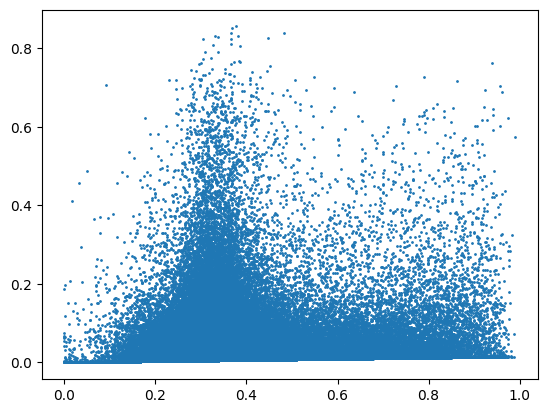

In [7]:
plt.figure(); plt.scatter(homology_scores[0][1], model.scores_0_1,s=1)

Best model path: logs/metrics/version_306/checkpoints/epoch=39-step=1280.ckpt


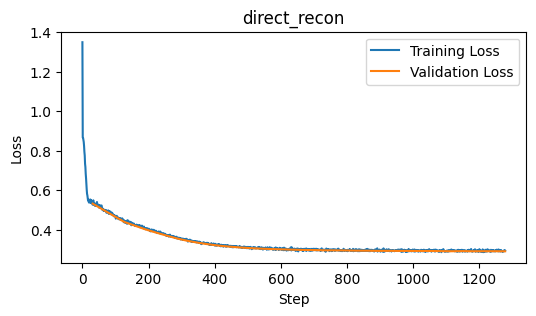

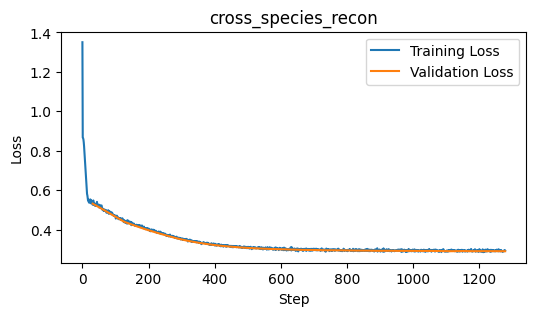

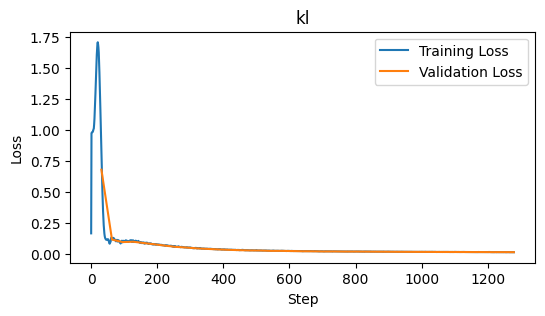

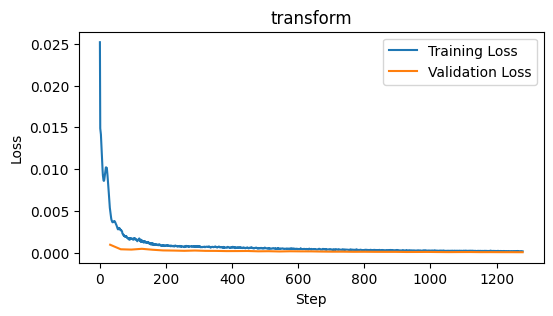

In [8]:
,# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["direct_recon", "cross_species_recon", "kl", "transform"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}'][df[f'val_{loss_type}'] != 0.0]
    val_step = df['step'][df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

    
best_model_path = trainer.callbacks[-1].best_model_path
print("Best model path:", best_model_path)
# # Load the checkpoint
# checkpoint = torch.load(best_model_path)

# # Create a new model with the same hyperparameters and homology information
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,  # Need to pass these again
#     **checkpoint['hyper_parameters']  # This loads all other hyperparameters
# )

# # Load the state dict
# model.load_state_dict(checkpoint['state_dict'])

# Saving
# save_dict = {
#     'state_dict': model.state_dict(),
#     'hyper_parameters': model.hparams,
#     'epoch': 99,
# }
# torch.save(save_dict, f'manual_checkpoint_epoch_{99}.pt')

In [9]:
output, s = model.get_latent_embeddings(species_data_sub, batch_size=32)
s=s.cpu().numpy()

In [10]:
plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())

<Figure size 640x480 with 0 Axes>

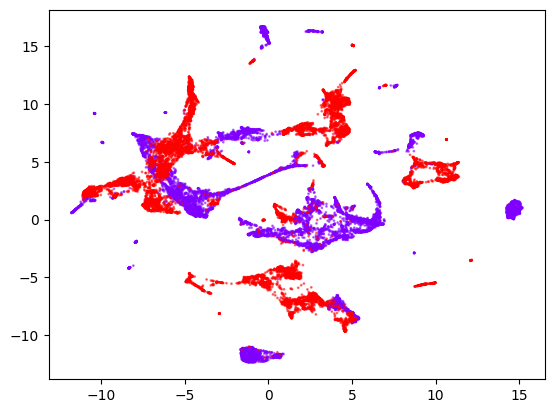

In [11]:
plt.scatter(dt_full[:,0],dt_full[:,1],c=s,s=1, alpha=0.5, cmap='rainbow');

0.49384624602077254
0.5058045447745405


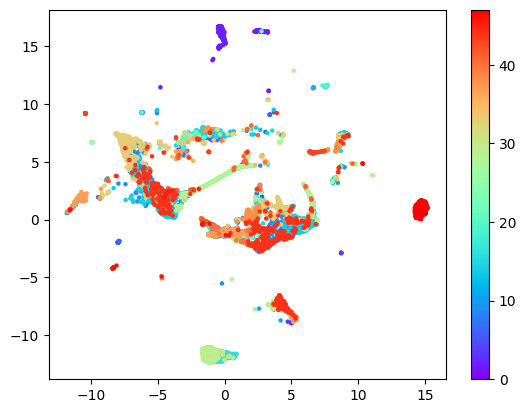

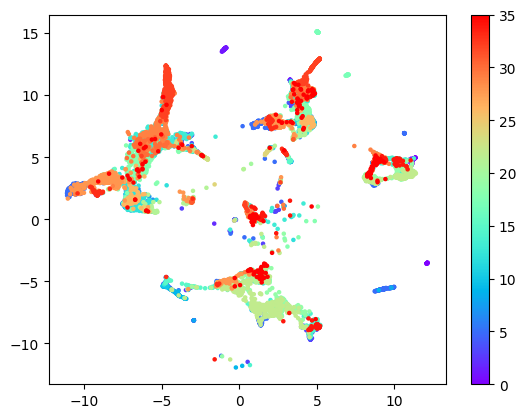

In [12]:

#output, s = model.get_latent_embeddings(species_data)
#s=s.cpu().numpy()

#plt.figure();
#dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
#plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1], [species_data_sub['wagner'], species_data_sub['briggs']], ['cell_type', 'cell_type']):
    dt = dt_full[s==i] # umap.UMAP(n_components=2).fit_transform(output[s==i].detach().cpu().numpy())

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

In [13]:
import numpy as np
import plotly.io as pio
pio.renderers.default = "notebook"



import plotly.graph_objects as go
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import plotly.io as pio
pio.renderers.default = 'notebook'
def create_sankey_from_similarity(
    similarity_matrix: np.ndarray,
    source_labels: list,
    target_labels: list,
    threshold: float = 0.1,
    title: str = "Cross-species Label Similarity",
    width: int = 1000,
    height: int = 800
) -> go.Figure:
    """
    Create a Sankey diagram from a bipartite similarity matrix with weighted edges.
    """
    # Create node labels
    labels = source_labels + target_labels
    
    # Create source, target, and value arrays for links
    sources = []
    targets = []
    values = []
    
    # Create hover text for links
    link_labels = []
    
    # Iterate through similarity matrix
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if similarity_matrix[i,j] > threshold:
                sources.append(i)
                targets.append(j + len(source_labels))
                values.append(similarity_matrix[i,j])
                link_labels.append(f"{source_labels[i]} → {target_labels[j]}: {similarity_matrix[i,j]:.3f}")
    
    # Normalize values to make them more visually appealing
    values = np.array(values)
    values = values / values.max() * 100  # Scale to 0-100 range for better visualization
    
    # Create color arrays for nodes
    node_colors = ['#1f77b4'] * len(source_labels) + ['#ff7f0e'] * len(target_labels)
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = labels,
            color = node_colors
        ),
        link = dict(
            source = sources,
            target = targets,
            value = values,
            customdata = link_labels,
            color = ['rgba(31, 119, 180, 0.4)'] * len(sources),  # Semi-transparent links
            hovertemplate = '%{customdata}<extra></extra>'
        )
    )])
    
    # Update layout
    fig.update_layout(
        title_text=title,
        font_size=12,
        width=width,
        height=height,
        showlegend=False,
        margin=dict(t=40, l=40, r=40, b=40)
    )
    
    # Display in notebook
    # fig.show(renderer="notebook")
    return fig

def format_cross_species_similarities(
    similarity_matrix: np.ndarray,
    source_labels: np.ndarray,
    target_labels: np.ndarray,
    source_species: str = "wagner",
    target_species: str = "briggs",
    top_n: int | None = None
) -> pd.DataFrame:
    """
    Format similarity matrix into a DataFrame with columns for each species-cell type combination.
    
    Args:
        similarity_matrix: NxM matrix of similarities
        source_labels: N labels from source species
        target_labels: M labels from target species
        source_species: Name of source species
        target_species: Name of target species
        top_n: Optional number of top matches to include (None for all)
    """
    # Create columns for both species
    columns = pd.MultiIndex.from_tuples(
        # Wagner columns
        [(source_species, cell_type, col_name)
         for cell_type in source_labels
         for col_name in ['matched_type', 'similarity']] +
        # Briggs columns
        [(target_species, cell_type, col_name)
         for cell_type in target_labels
         for col_name in ['matched_type', 'similarity']]
    )
    
    # Initialize DataFrame
    max_rows = max(
        len(target_labels) if top_n is None else top_n,
        len(source_labels) if top_n is None else top_n
    )
    df = pd.DataFrame(index=range(max_rows), columns=columns)
    
    # Fill Wagner -> Briggs mappings
    for i, source_label in enumerate(source_labels):
        similarities = similarity_matrix[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(source_species, source_label, 'matched_type')] = target_labels[sorted_indices]
        df[(source_species, source_label, 'similarity')] = similarities[sorted_indices]
    
    # Fill Briggs -> Wagner mappings (using transposed similarity matrix)
    similarity_matrix_T = similarity_matrix.T
    for i, target_label in enumerate(target_labels):
        similarities = similarity_matrix_T[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(target_species, target_label, 'matched_type')] = source_labels[sorted_indices]
        df[(target_species, target_label, 'similarity')] = similarities[sorted_indices]
    
    return df

K = 50
latent = output.cpu().numpy()

nnm = _united_proj(latent[s==1],latent[s==0], k=K, metric='cosine')
x, y = nnm.nonzero()
indices_x = x.reshape((nnm.shape[0],K))
indices_y = y.reshape((nnm.shape[0],K))
similarities = nnm.data.reshape((nnm.shape[0],K))


cl1 = np.array(list(species_data_sub['wagner'].obs['cell_type']))
cl2 = np.array(list(species_data_sub['briggs'].obs['cell_type']))

clu1,cluc1 = np.unique(cl1, return_counts=True)
clu2,cluc2 = np.unique(cl2, return_counts=True)

C = np.zeros((clu1.size,clu2.size))


df = pd.DataFrame();
df['labels_0'] = cl1[indices_y].flatten()
df['labels_1'] = cl2[indices_x].flatten()
df['similarities'] = similarities.flatten()
df = df.groupby(['labels_0','labels_1']).sum().reset_index()

C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)


# mapping tables

In [14]:
pd.set_option('display.max_columns', None)

# Create the DataFrame with top 5 matches
similarity_df = format_cross_species_similarities(C, clu1, clu2, top_n=10)

In [15]:
similarity_df['briggs']

Blastula                              Blood             \
              matched_type similarity            matched_type similarity   
0              pluripotent   6.915054                   Blood   6.664264   
1                 Germline   0.321984                   Optic   3.452635   
2                   Neuron   0.125411            Neural crest   1.006714   
3        Olfactory placode   0.113998      Forebrain/midbrain   0.800017   
4       Rohon-beard neuron   0.083002                  Neuron   0.389005   
5                  Tailbud   0.001676         Skeletal muscle   0.311743   
6       Forebrain/midbrain   0.001201  Neural crest - crestin   0.284335   
7                Hindbrain   0.000670                   Heart   0.248572   
8  Rare epidermal subtypes   0.000000               Hindbrain   0.241314   
9          Pronephric duct   0.000000                Endoderm   0.237173   

   Cement gland primordium                             Endoderm             \
              matched_type similarity              matched_type similarity   
0                 periderm  24.459286               Endothelial   6.865047   
1        Olfactory placode   2.283243          Dorsal organizer   5.748515   
2  Rare epidermal subtypes   1.853323                  Endoderm   4.675786   
3              Endothelial   1.749856                 Notochord   3.301884   
4          Pronephric duct   1.350921  Involuting marginal zone   2.540210   
5      Pancreas primordium   0.943749       Presomitic mesoderm   2.351918   
6                      EVL   0.779218      Epidermal progenitor   2.204231   
7                 Ionocyte   0.709493     Intermediate mesoderm   1.316558   
8     Epidermal progenitor   0.703274                     Heart   1.253251   
9                Notoplate   0.699288             Placodal area   1.200775   

             Endothelial              Epidermal progenitor             \
            matched_type similarity           matched_type similarity   
0           Neural crest   5.673450          Placodal area   8.769850   
1            Endothelial   4.842743            Endothelial   7.549632   
2                  Heart   4.415466   Epidermal progenitor   5.114614   
3  Intermediate mesoderm   1.630868          Neuroectoderm   5.111422   
4                   Lens   0.756758            pluripotent   4.959895   
5                  Optic   0.730624    Non-neural ectoderm   3.310336   
6               Endoderm   0.696098                 Neuron   2.956401   
7        Skeletal muscle   0.670460       Pharyngeal pouch   1.952838   
8   Neural crest - mcamb   0.632705  Intermediate mesoderm   1.196630   
9       Pharyngeal pouch   0.631113              Notoplate   1.183662   

                  Eye primordium                    Forebrain/midbrain  \
                    matched_type similarity               matched_type   
0                      Hindbrain   3.213950                  Hindbrain   
1             Forebrain/midbrain   2.171110         Forebrain/midbrain   
2                         Neuron   1.426935                     Neuron   
3                        Tailbud   1.347832                    Tailbud   
4                          Optic   0.589303                      Optic   
5  neural - floorplate posterior   0.197035         Rohon-beard neuron   
6             Rohon-beard neuron   0.192819      Intermediate mesoderm   
7      Neural crest - iridoblast   0.175137                Endothelial   
8              Olfactory placode   0.119328  Neural crest - iridoblast   
9                          Blood   0.118797                      Heart   

                              Germline                          Goblet cell  \
  similarity              matched_type similarity              matched_type   
0   2.371932          Dorsal organizer   0.753879                  periderm   
1   1.982113                  periderm   0.726804          Dorsal organizer   
2   1.871620          Apoptotic-like 2   0.663290                       EVL   
3   0.5

In [17]:
similarity_df['wagner']

Apoptotic-like                     Apoptotic-like 2             \
               matched_type similarity              matched_type similarity   
0                  Endoderm   0.722041                  Germline   0.163491   
1      Epidermal progenitor   0.211979       Non-neural ectoderm   0.153980   
2                  Blastula   0.187044                  Ionocyte   0.078254   
3       Non-neural ectoderm   0.159111               Goblet cell   0.051531   
4  Involuting marginal zone   0.098494                  Endoderm   0.023296   
5                  Germline   0.076573             Neuroectoderm   0.021217   
6             Neuroectoderm   0.067742         Spemann organizer   0.018141   
7               Goblet cell   0.051176  Involuting marginal zone   0.007620   
8                  Ionocyte   0.043638      Epidermal progenitor   0.005372   
9         Spemann organizer   0.036078           Skeletal muscle   0.000000   

                   Blood                     Dorsal organizer             \
            matched_type similarity              matched_type similarity   
0        Skeletal muscle  40.156135               Goblet cell   1.764261   
1    Presomitic mesoderm   3.472965                  Blastula   1.080749   
2  Intermediate mesoderm   2.888745                  Endoderm   0.558211   
3                  Blood   0.823789       Non-neural ectoderm   0.109274   
4                Tailbud   0.386143             Neuroectoderm   0.080933   
5    Myeloid progenitors   0.293893                  Ionocyte   0.068677   
6  Pronephric mesenchyme   0.195098                  Germline   0.052953   
7            Endothelial   0.134658  Involuting marginal zone   0.026580   
8      Spemann organizer   0.105725         Spemann organizer   0.018080   
9           Neural crest   0.078862   Cement gland primordium   0.014871   

                       EVL                         Endoderm             \
              matched_type similarity          matched_type similarity   
0              Goblet cell   5.219519             Notochord   5.903307   
1           Hatching gland   4.790729   Non-neural ectoderm   2.146663   
2  Cement gland primordium   2.875137              Endoderm   2.115004   
3                 Ionocyte   1.983157           Goblet cell   1.634851   
4                 Germline   0.972249              Ionocyte   1.228683   
5                 Endoderm   0.255506   Myeloid progenitors   0.672350   
6     Epidermal progenitor   0.145795           Endothelial   0.567707   
7      Non-neural ectoderm   0.083858  Epidermal progenitor   0.471875   
8                Notochord   0.041028              Blastula   0.463345   
9            Neuroectoderm   0.005324               Tailbud   0.403426   

             Endothelial                Epidermal progenitor             \
            matched_type similarity             matched_type similarity   
0          Placodal area  12.230129     Epidermal progenitor   8.533394   
1   Epidermal progenitor   6.462339    Small secretory cells   5.241693   
2                  Blood   5.587402      Myeloid progenitors   2.010489   
3            Endothelial   5.280518            Placodal area   2.003488   
4                   Lens   4.516954                 Ionocyte   1.961250   
5           Otic placode   4.507668                Notochord   1.080469   
6           Neural crest   4.270555      Non-neural ectoderm   0.656977   
7               Endoderm   3.842155                 Endoderm   0.456526   
8                  Optic   2.870322  Cement gland primordium   0.448906   
9  Small secretory cells   2.785182              Goblet cell   0.268693   

             Eye primordium                Forebrain/midbrain             \
               matched_type similarity           matched_type similarity   
0         Spemann organizer   0.926635  Intermediate mesoderm  12.152008   
1  Involuting marginal zone   0.655589              Hindbrain   7.101276   
2                   Tailbud   0.652395           Neural c

In [18]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

2024-12-10 23:24:26,142 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-10 23:24:28,358 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-10 23:24:28,405 - harmonypy - INFO - Iteration 1 of 10
2024-12-10 23:24:32,256 - harmonypy - INFO - Iteration 2 of 10
2024-12-10 23:24:36,138 - harmonypy - INFO - Iteration 3 of 10
2024-12-10 23:24:40,020 - harmonypy - INFO - Iteration 4 of 10
2024-12-10 23:24:43,805 - harmonypy - INFO - Iteration 5 of 10
2024-12-10 23:24:47,325 - harmonypy - INFO - Iteration 6 of 10
2024-12-10 23:24:50,131 - harmonypy - INFO - Iteration 7 of 10
2024-12-10 23:24:53,354 - harmonypy - INFO - Iteration 8 of 10
2024-12-10 23:24:56,136 - harmonypy - INFO - Iteration 9 of 10
2024-12-10 23:24:59,151 - harmonypy - INFO - Iteration 10 of 10
2024-12-10 23:25:01,673 - harmonypy - INFO - Stopped before convergence


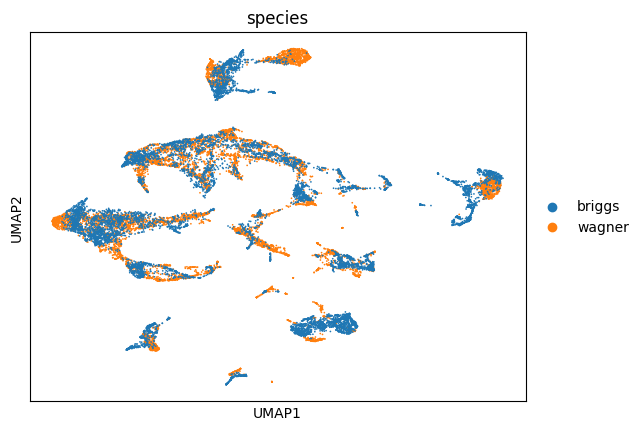

In [19]:
sc.pl.umap(adata,color='species')

In [20]:
K = 50
latent = adata.obsm['X_pca_harmony']

nnm = _united_proj(latent[s==1],latent[s==0], k=K, metric='cosine')
x, y = nnm.nonzero()
indices_x = x.reshape((nnm.shape[0],K))
indices_y = y.reshape((nnm.shape[0],K))
similarities = nnm.data.reshape((nnm.shape[0],K))


cl1 = np.array(list(species_data_sub['wagner'].obs['cell_type']))
cl2 = np.array(list(species_data_sub['briggs'].obs['cell_type']))

clu1,cluc1 = np.unique(cl1, return_counts=True)
clu2,cluc2 = np.unique(cl2, return_counts=True)

C = np.zeros((clu1.size,clu2.size))


df = pd.DataFrame();
df['labels_0'] = cl1[indices_y].flatten()
df['labels_1'] = cl2[indices_x].flatten()
df['similarities'] = similarities.flatten()
df = df.groupby(['labels_0','labels_1']).sum().reset_index()

C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)


In [21]:
similarity_df = format_cross_species_similarities(C, clu1, clu2, top_n=10)

In [22]:
similarity_df['briggs']

Blastula                              Blood             \
               matched_type similarity            matched_type similarity   
0               pluripotent   5.249238            Neural crest   3.926388   
1             Neuroectoderm   1.292329   Intermediate mesoderm   3.436975   
2  Involuting marginal zone   1.066237                   Heart   2.055098   
3       Non-neural ectoderm   0.662371             Endothelial   1.794724   
4          Dorsal organizer   0.207832      Forebrain/midbrain   1.228215   
5                  Germline   0.020755    Neural crest - mcamb   0.996961   
6            Apoptotic-like   0.020752                 Tailbud   0.980473   
7                 Notochord   0.010389  Neural crest - crestin   0.696658   
8                  Endoderm   0.007124               Hindbrain   0.682460   
9                  periderm   0.000000                   Optic   0.545134   

   Cement gland primordium                             Endoderm             \
              matched_type similarity              matched_type similarity   
0                 periderm  23.194162  Involuting marginal zone   7.607170   
1  Rare epidermal subtypes   5.058327       Presomitic mesoderm   2.967540   
2                 Ionocyte   4.872107               Endothelial   2.873724   
3              Endothelial   2.345757             Neuroectoderm   2.744133   
4      Secretory epidermal   1.370410       Non-neural ectoderm   2.439079   
5                Notochord   0.996065                Macrophage   1.849157   
6           Hatching gland   0.869625                  Endoderm   1.590671   
7               Macrophage   0.652990               pluripotent   1.331529   
8                    Heart   0.646835     Intermediate mesoderm   1.281016   
9          Pronephric duct   0.622516          Dorsal organizer   1.167447   

              Endothelial                Epidermal progenitor             \
             matched_type similarity             matched_type similarity   
0            Neural crest   3.540728     Epidermal progenitor  12.820599   
1   Intermediate mesoderm   2.038504              Endothelial   7.398915   
2                   Heart   2.031180  Rare epidermal subtypes   4.286255   
3             Endothelial   1.147489                 periderm   4.235651   
4      Forebrain/midbrain   0.690382            Placodal area   3.936681   
5  Neural crest - crestin   0.664702      Non-neural ectoderm   2.444598   
6              Macrophage   0.643401                    Heart   2.416658   
7               Hindbrain   0.485818            Neuroectoderm   2.008769   
8                 Tailbud   0.480181    Intermediate mesoderm   1.536131   
9                Endoderm   0.391629              pluripotent   1.428811   

          Eye primordium                Forebrain/midbrain             \
            matched_type similarity           matched_type similarity   
0              Hindbrain   3.312612              Hindbrain   2.928163   
1     Forebrain/midbrain   2.557600     Forebrain/midbrain   2.151324   
2                Tailbud   1.619996                Tailbud   0.706211   
3           Neural crest   0.501092                 Neuron   0.510702   
4  Intermediate mesoderm   0.404305  Intermediate mesoderm   0.306775   
5                 Neuron   0.272119           Neural crest   0.149270   
6         Eye primordium   0.179374      Olfactory placode   0.127067   
7   Epidermal progenitor   0.141491          Placodal area   0.117284   
8          Placodal area   0.091884            Endothelial   0.083000   
9                  Heart   0.078091               Endoderm   0.066477   

                   Germline                          Goblet cell             \
               matched_type similarity              matched_type similarity   
0                  periderm   0.713741                  periderm  21.879260   
1          Dorsal organizer   0.269137                  Ionocyte   7.986237   
2  Involuting marginal zone   0.259655   Rare epide

In [23]:
similarity_df['wagner']

Apoptotic-like                     Apoptotic-like 2             \
               matched_type similarity              matched_type similarity   
0                  Endoderm   0.643462       Non-neural ectoderm   0.151394   
1             Neuroectoderm   0.426401                  Ionocyte   0.104944   
2  Involuting marginal zone   0.236076               Goblet cell   0.017300   
3       Non-neural ectoderm   0.150421             Neuroectoderm   0.007993   
4         Spemann organizer   0.108709  Involuting marginal zone   0.007617   
5                  Germline   0.076797      Epidermal progenitor   0.004308   
6      Epidermal progenitor   0.074064         Spemann organizer   0.000000   
7                  Ionocyte   0.026251                   Tailbud   0.000000   
8                  Blastula   0.020752           Skeletal muscle   0.000000   
9               Goblet cell   0.011514     Small secretory cells   0.000000   

                   Blood                  Dorsal organizer             \
            matched_type similarity           matched_type similarity   
0        Skeletal muscle  39.114862            Goblet cell   1.910660   
1    Presomitic mesoderm   1.675016               Endoderm   1.167447   
2  Intermediate mesoderm   1.475708              Notochord   0.592727   
3                  Blood   0.336534               Germline   0.269137   
4   Epidermal progenitor   0.209057               Ionocyte   0.218480   
5  Pronephric mesenchyme   0.190077               Blastula   0.207832   
6                Tailbud   0.141182    Non-neural ectoderm   0.152257   
7            Endothelial   0.085734   Epidermal progenitor   0.039820   
8          Placodal area   0.066965          Neuroectoderm   0.017319   
9      Spemann organizer   0.053183  Small secretory cells   0.000000   

                       EVL                         Endoderm             \
              matched_type similarity          matched_type similarity   
0              Goblet cell   2.995763             Notochord   9.453892   
1                 Ionocyte   0.619268   Non-neural ectoderm   2.619502   
2  Cement gland primordium   0.280552              Endoderm   1.590671   
3                 Germline   0.249212           Goblet cell   1.386433   
4      Non-neural ectoderm   0.124332              Ionocyte   1.046604   
5     Epidermal progenitor   0.037716  Epidermal progenitor   0.682333   
6                 Endoderm   0.032618         Placodal area   0.446543   
7            Neuroectoderm   0.005329   Myeloid progenitors   0.398449   
8          Skeletal muscle   0.000000           Endothelial   0.391629   
9    Small secretory cells   0.000000         Neuroectoderm   0.334356   

               Endothelial                Epidermal progenitor             \
              matched_type similarity             matched_type similarity   
0            Placodal area  10.461051     Epidermal progenitor  12.820599   
1     Epidermal progenitor   7.398915    Small secretory cells   8.209819   
2    Small secretory cells   6.905215            Placodal area   5.795819   
3                     Lens   4.067757      Non-neural ectoderm   4.211885   
4             Otic placode   3.967001                 Ionocyte   4.005030   
5                 Endoderm   2.873724              Goblet cell   0.424835   
6  Cement gland primordium   2.345757  Cement gland primordium   0.414211   
7                    Blood   1.794724      Neuroendocrine cell   0.279616   
8              Endothelial   1.147489                Hindbrain   0.200518   
9        Olfactory placode   1.076313                 Endoderm   0.187397   

             Eye primordium                Forebrain/midbrain             \
               matched_type similarity           matched_type similarity   
0         Spemann organizer   0.652559  Intermediate mesoderm  11.905168   
1                   Tailbud   0.591446              Hindbrain   7.805650   
2             Neuroectoderm   0.496912           Neural crest   7.386